In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import warnings
warnings.filterwarnings('ignore')
import pandas_ta as ta
import os

In [2]:
import requests
from requests_html import HTMLSession
session = HTMLSession()
num_currencies=250
resp = session.get(f"https://finance.yahoo.com/crypto?offset=0&count={num_currencies}")
tables = pd.read_html(resp.html.raw_html)               
df = tables[0].copy()
symbols_yf = df.Symbol.tolist()

[*********************100%***********************]  1 of 1 completed
[X] value is not a number
0 19
[X] value is not a number
              precision    recall  f1-score   support

         0.0       0.54      0.45      0.49      1007
         1.0       0.47      0.56      0.51       890

    accuracy                           0.50      1897
   macro avg       0.50      0.50      0.50      1897
weighted avg       0.51      0.50      0.50      1897

scores:  [0.50265957 0.51897185 0.54005168 0.50732357 0.4972973 ]
[*********************100%***********************]  1 of 1 completed
[X] value is not a number
0 19
[X] value is not a number
              precision    recall  f1-score   support

         0.0       0.50      0.48      0.49       966
         1.0       0.48      0.50      0.49       931

    accuracy                           0.49      1897
   macro avg       0.49      0.49      0.49      1897
weighted avg       0.49      0.49      0.49      1897

scores:  [0.51554404 0.51464

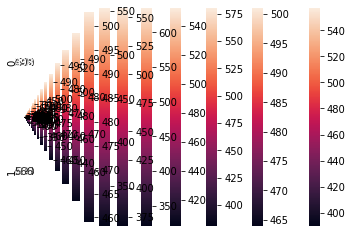

In [3]:
for symbol in symbols_yf:
    try:
        # download ethereum data from yfinance
        eth = yf.download(symbol, start='2022-01-01', interval='1h')

        # convert to pandas dataframe
        eth = pd.DataFrame(eth)


        list = ["above_value", "accbands", "ad", "adosc", "adx",\
            "amat", "aobv", "apo", "aroon", "atr", "bbands", \
            "below_value", "bias", "bop", "brar", "cci", "cdl_z", \
            "cfo", "cg", "chop", "cksp", "cmf", "cmo", "coppock", \
            "cross_value", "cti", "decay", "decreasing", "dema", "dm", "donchian", \
            "ebsw", "efi", "ema", "entropy", "eom", "er", "eri", "fisher", "fwma", "ha", \
            "hl2", "hlc3", "hma", "hwc", "hwma", "increasing", "inertia", \
            "jma", "kama", "kc", "kdj", "kst", "kurtosis", "kvo", "linreg", "log_return", \
            "long_run", "macd", "mad", "massi", "mcgd", "median", "mfi", "midpoint", \
            "midprice", "mom", "natr", "nvi", "obv", "ohlc4", "pdist", "percent_return", \
            "pgo", "ppo", "psl", "pvi", "pvo", "pvol", "pvr", "pvt", "pwma", \
            "qstick", "quantile", "rma", "roc", "rsi", "rsx", "rvgi", "rvi", "short_run", \
            "sinwma", "skew", "slope", "sma", "smi", "squeeze", "squeeze_pro", "ssf", "stc", \
            "stdev", "stoch", "stochrsi", "swma", "t3", "tema", "thermo", \
            "tos_stdevall", "trima", "trix", "true_range", "tsi", "tsignals", "ttm_trend", "ui", \
            "uo", "variance", "vhf", "vidya", "vortex", "vwap", "vwma", "wcp", "willr", \
            "wma", "xsignals", "zlma", "zscore"]

        best_indicators = []
        len_eth = len(eth)
        first_date = eth.index[0]
        i = 0
        for item in list:
            temp = eth.copy()
            temp = eval(f"temp.ta.{item}(inplace=True)")
            temp.dropna(inplace=True)
            date_now = temp.index[0]
            difference_len = len_eth - len(temp)
            # compare how many days between first_date and date_now
            delta = date_now - first_date
            difference_days = delta.days
            if difference_days > 200:
                print("over 200 days gone")
                break
            if difference_days != difference_len:
                print(difference_days, difference_len)
                break
            best_indicators.append(item)
            i += 1
        for item in best_indicators:
            temp = eval(f"eth.ta.{item}()")
            # add temp to eth
            eth = eth.join(temp, how="outer", rsuffix=f"_{item}")

        eth.dropna(inplace=True)

        # make all values pct_change unless they are categorical
        eth = eth.pct_change()

        # change inf to 0
        eth = eth.replace([np.inf, -np.inf], 0)

        # add a column for day of the week
        eth['day_of_week'] = eth.index.dayofweek

        i = 0
        # check what columns have nan values
        for col in eth.columns:
            na = eth[col].isna().sum()
            if na > 10:
                i += 1
                eth = eth.drop([col], axis=1)

        # make the target close 1 if its less than 0 and 0 if its greater than 0
        eth['target_close'] = np.where(eth['Close'] < 0, 1, 0)

        # shift it once
        eth['target_close'] = eth['target_close'].shift(-1)

        eth.dropna(inplace=True)

        # split the data with built-in function train_test_split
        from sklearn.model_selection import train_test_split

        X = eth.drop('target_close', axis=1)
        y = eth['target_close']

        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)

        # scale the data
        from sklearn.preprocessing import MinMaxScaler
        scaler = MinMaxScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)

        # convert the scaled data to dataframe
        X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns, index=X_train.index)
        X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns, index=X_test.index)

        # lightgbm classifier
        import lightgbm as lgb

        # create the model
        model = lgb.LGBMClassifier()

        # fit the model
        model.fit(X_train_scaled, y_train)

        # predict the model
        y_pred = model.predict(X_test_scaled)

        # check the accuracy
        from sklearn.metrics import accuracy_score

        accuracy = accuracy_score(y_test, y_pred)

        # check the confusion matrix
        from sklearn.metrics import confusion_matrix

        # pretty print the confusion matrix
        import seaborn as sns

        cm = confusion_matrix(y_test, y_pred)
        sns.heatmap(cm, annot=True, fmt="d")
        tn, fp, fn, tp = cm.ravel()

        # check the classification report
        from sklearn.metrics import classification_report

        print(classification_report(y_test, y_pred))

        # cross validation
        from sklearn.model_selection import cross_val_score

        scores = cross_val_score(model, X_train_scaled, y_train, cv=5, scoring="precision")
        print("scores: ", scores)

        # avg score
        avg_score = scores.mean()

        filename = 'results_1h.txt'

        mode = 'a' if os.path.exists(filename) else 'w'
        with open(filename, mode) as f:
            # write the symbol to f
            f.write(f"symbol: {symbol} | ")
            # how many data points
            f.write(f"length: {len(y_test)} | ")
            # write accuracy to f
            f.write(f"accuracy: {accuracy} | ")
            # write cross_val_scores
            f.write(f"cross_val_scores: {scores} | ")
            # write cross_val_scores
            f.write(f"cross_val_scores_avg: {avg_score} | ")
            # write precision to f
            f.write(f"precision: {tp/(tp+fp)} | ")
            # write cm to f
            f.write(f"tn: {tn}, fp: {fp}, fn: {fn}, tp: {tp} | ")
            # new line
            f.write("\n")
    except:
        continue